In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd

import xarray as xr
import geopandas
import rioxarray
from shapely.ops import unary_union

sys.path.append(os.path.join(".."))
import process, correlation

### Variables

In [4]:
# Define time period for analysis
YEAR_START = 2015
YEAR_END = 2022

In [5]:
# List ssp scenarios to consider
ssps = [
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp585"
    ]

# Specify scenario for plots
ssp_cur = "ssp585"

# Set varible to run comparison (choose one option)
var = "temperature"
# var = "precipitation"

### Some preparation

In [6]:
# Collect ensembles of the models in dictionary
ensembles = {
        "models_low_ECS": ["CAMS-CSM1-0",
                "INM-CM4-8",
                "MIROC6",
                "MPI-ESM1-2-HR",
                "NorESM2-MM"],

        "models_medium_ECS": ["AWI-CM-1-1-MR",
                "BCC-CSM2-MR",
                "CMCC-ESM2",
                "EC-Earth3",
                "GFDL-ESM4",
                "MRI-ESM2-0"],
                
        "models": ["ACCESS-CM2",
                "AWI-CM-1-1-MR",
                "BCC-CSM2-MR",
                "CanESM5",
                "CAMS-CSM1-0",
                "CMCC-ESM2",
                "CNRM-CM6-1",
                "EC-Earth3",
                "GFDL-ESM4",
                "INM-CM4-8",
                "IPSL-CM6A-LR",
                "MIROC6",
                "MPI-ESM1-2-HR",
                "MRI-ESM2-0",
                "NorESM2-MM",
                "UKESM1-0-LL"]
}

# Set the name of the ensemble to use
ens_name = "models"

In [7]:
# Coordinate bounds (limits Russia roughly)
LEFT = 20
RIGHT = 180
TOP = 82
BOTTOM = 41
bounds = (LEFT, RIGHT, TOP, BOTTOM)

In [8]:
# Years range
years = np.arange(YEAR_START,YEAR_END+1)

# Set main folders
path_data = '/CMIPProximity/data/'
path_data_processed = '/CMIPProximity/data_processed/'
path_pics = "/CMIPProximity/data_processed/pics"

# Create folders to process data
os.makedirs(path_pics, exist_ok = True)
os.makedirs(path_data_processed + "yearly", exist_ok = True)
os.makedirs(os.path.join(path_data_processed ,
                        "{}_{}".format(years[0], years[-1])),
            exist_ok = True)
for ssp in ssps:
    os.makedirs(os.path.join(path_data_processed,
                            "yearly",
                            ssp),
                exist_ok = True)
    os.makedirs(os.path.join(path_data_processed,
                            "{}_{}".format(years[0], years[-1]),
                            ssp),
                exist_ok = True)

In [18]:
# Load country boundaries
gdf_country = geopandas.read_file(os.path.join(path_data, 'gadm41_RUS_0.json'))
gdf_country = gdf_country.rename(columns={'COUNTRY': 'NAME_1'})

# The same on regional level
gdf_region = geopandas.read_file(os.path.join(path_data, 'gadm41_RUS_2.json'))
gdf_region.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,RUS.1.1_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Giaginskiyrayon,NA,Гиагинскийрайон,Raion,District,R43010,RU.AD.GI,"MULTIPOLYGON (((40.56050 44.89230, 40.50130 44..."
1,RUS.1.2_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Koshekhabl'skiyrayon,NA,Кошехабaльскийрайон,Raion,District,R43010,RU.AD.KO,"MULTIPOLYGON (((40.45650 44.75390, 40.47690 44..."
2,RUS.1.3_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Krasnogvardeyskiyrayon,NA,Красногвардейскийрайон,Raion,District,R43010,RU.AD.KR,"MULTIPOLYGON (((40.02920 45.06250, 40.01730 45..."
3,RUS.1.4_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Maykop,NA,Майкоп,Gorsovet,District,NA,RU.AD.MG,"MULTIPOLYGON (((40.13180 44.60050, 40.11040 44..."
4,RUS.1.5_1,RUS,Russia,RUS.1_1,Adygey,РеспубликаАдыгея,Maykopskiyrayon,NA,Майкопскийрайон,Raion,District,R43010,RU.AD.MR,"MULTIPOLYGON (((40.04870 44.77320, 40.07800 44..."


In [20]:
# Load dictionary with regions included in federal districts
with open(os.path.join(path_data, "districts_Anis.json"), 'r') as file:
    districts = json.load(file)

# Collect district boundaries by union those of corresponding regions
gdf_districts = pd.DataFrame(columns=['district', "geometry"])
gdf_districts.loc[0, "district"] = "РФ"
gdf_districts.loc[0, "geometry"] = gdf_country.loc[0, 'geometry']

for index, (district_name, district_regions) in enumerate(districts.items()):
    region_dict = districts[district_name]
    lines = pd.DataFrame(columns=gdf_region.columns)
    for name, areas in region_dict.items():
    # for record in region_list:
        if len(areas)==0:
            lines = pd.concat([lines, gdf_region.loc[gdf_region['NAME_1'].isin([name])]], axis=0)
        else:
            lines = pd.concat([lines, gdf_region.loc[gdf_region['NAME_1'].isin([name])& gdf_region['NAME_2'].isin(areas)]], axis=0)
    united_geom = unary_union(lines['geometry'])
    gdf_districts.loc[index+1, "district"] = district_name
    gdf_districts.loc[index+1, "geometry"] = united_geom

/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-p

## Average data yearly

In [109]:
# Calculate yearly average of ERA data pixelwise
height, width = process.average_year_era(path_data,
                path_data_processed,
                var,
                years)

/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view 

In [121]:
# Calculate yearly average of CMIP data pixelwise for models ensemble
process.average_cmip_model(
    ensembles[ens_name],
    ssps,
    years,
    var,
    path_data,
    path_data_processed,
    height,
    width
)

ssp370


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:03<00:53,  3.57s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:22<00:59,  4.99s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:34<00:49,  4.94s/it]/home/crop_dev/minicond

2015 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:05,  2.86it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:07<00:19,  1.59s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:07,  1.27it/s]/home/crop_dev/minicond

2016 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:05,  2.86it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:08<00:20,  1.73s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:08,  1.16it/s]/home/crop_dev/minicond

2017 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:05,  2.80it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:08<00:19,  1.65s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:08,  1.22it/s]/home/crop_dev/minicond

2018 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:07,  2.13it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:08<00:20,  1.67s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:08,  1.21it/s]/home/crop_dev/minicond

2019 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:06,  2.29it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:07<00:19,  1.60s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:07,  1.26it/s]/home/crop_dev/minicond

2020 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:07,  2.14it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:07<00:19,  1.60s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:07,  1.26it/s]/home/crop_dev/minicond

2021 saved


  0%|          | 0/16 [00:00<?, ?it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
  6%|▋         | 1/16 [00:00<00:05,  2.59it/s]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 25%|██▌       | 4/16 [00:07<00:18,  1.56s/it]/home/crop_dev/miniconda/envs/crop/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
 38%|███▊      | 6/16 [00:08<00:07,  1.28it/s]/home/crop_dev/minicond

2022 saved


In [117]:
# Average over CMIP ensemble
process.average_ensemble(
    ensembles,
    ens_name,
    ssps,
    var,
    path_data_processed,
    years)

## Average over few years

In [12]:
# Calculate ERA average over few years
process.average_era_years(
    var,
    path_data_processed,
    years)

In [118]:
# Calculate average of CMIP ensemble over few years
process.average_ensemble_years(
        ens_name,
        years,
        ssps,
        var,
        path_data_processed)

In [119]:
# Calculate average of single CMIP model over few years
process.average_cmip_years(
    ensembles,
    ens_name,
    years,
    ssps,
    var,
    path_data_processed)

## MAE of (CMIP - ERA) difference and its plot within borders

In [133]:
mae_scores_districts = correlation.calc_mae(
    ensembles,
    ens_name,
    ssp_cur,
    var,
    path_data_processed,
    path_pics,
    gdf_districts,
    should_plot = True
)
mae_scores_df = pd.DataFrame.from_dict(mae_scores_districts, orient='index').T
mae_scores_df.loc['mean'] = mae_scores_df.mean()
mae_scores_df.round(1)

,РФ,Центр,Северо-Запад,Юг,Северный Кавказ,Поволжье,Урал,Сибирь,Дальний Восток
ACCESS-CM2,2.6,2.9,4.1,1.4,3.0,2.5,2.9,2.4,2.2
AWI-CM-1-1-MR,1.1,0.5,0.6,2.9,4.3,1.2,0.5,0.9,1.4
BCC-CSM2-MR,1.8,0.9,3.7,0.9,2.6,1.0,2.0,1.7,1.4
CanESM5,2.2,0.7,1.7,2.0,3.3,1.4,2.5,2.4,2.3
CAMS-CSM1-0,2.5,3.3,4.5,1.8,2.7,2.4,2.9,2.3,1.9
CMCC-ESM2,1.2,0.4,1.0,1.7,2.9,0.6,0.5,1.2,1.5
CNRM-CM6-1,0.8,0.3,0.7,0.9,1.9,0.9,0.6,0.9,0.8
EC-Earth3,2.1,1.4,2.5,1.3,1.8,1.2,2.1,2.2,2.1
GFDL-ESM4,1.4,2.1,2.6,0.7,1.5,1.3,1.5,1.4,1.1
INM-CM4-8,1.8,1.5,3.3,0.8,2.7,1.8,2.4,1.5,1.4


,РФ,Центр,Северо-Запад,Юг,Северный Кавказ,Поволжье,Урал,Сибирь,Дальний Восток
ACCESS-CM2,67.0,70.0,65.0,87.0,316.0,76.0,59.0,70.0,58.0
AWI-CM-1-1-MR,122.0,100.0,86.0,93.0,278.0,84.0,100.0,127.0,135.0
BCC-CSM2-MR,82.0,37.0,91.0,88.0,249.0,75.0,40.0,80.0,88.0
CanESM5,87.0,135.0,76.0,128.0,272.0,142.0,60.0,79.0,80.0
CAMS-CSM1-0,112.0,152.0,181.0,134.0,289.0,164.0,117.0,116.0,72.0
CMCC-ESM2,68.0,28.0,64.0,79.0,241.0,60.0,65.0,81.0,57.0
CNRM-CM6-1,94.0,130.0,74.0,97.0,236.0,97.0,51.0,94.0,102.0
EC-Earth3,63.0,60.0,71.0,108.0,159.0,103.0,55.0,66.0,52.0
GFDL-ESM4,83.0,24.0,69.0,80.0,220.0,46.0,89.0,81.0,90.0
INM-CM4-8,95.0,52.0,67.0,75.0,242.0,43.0,56.0,92.0,120.0


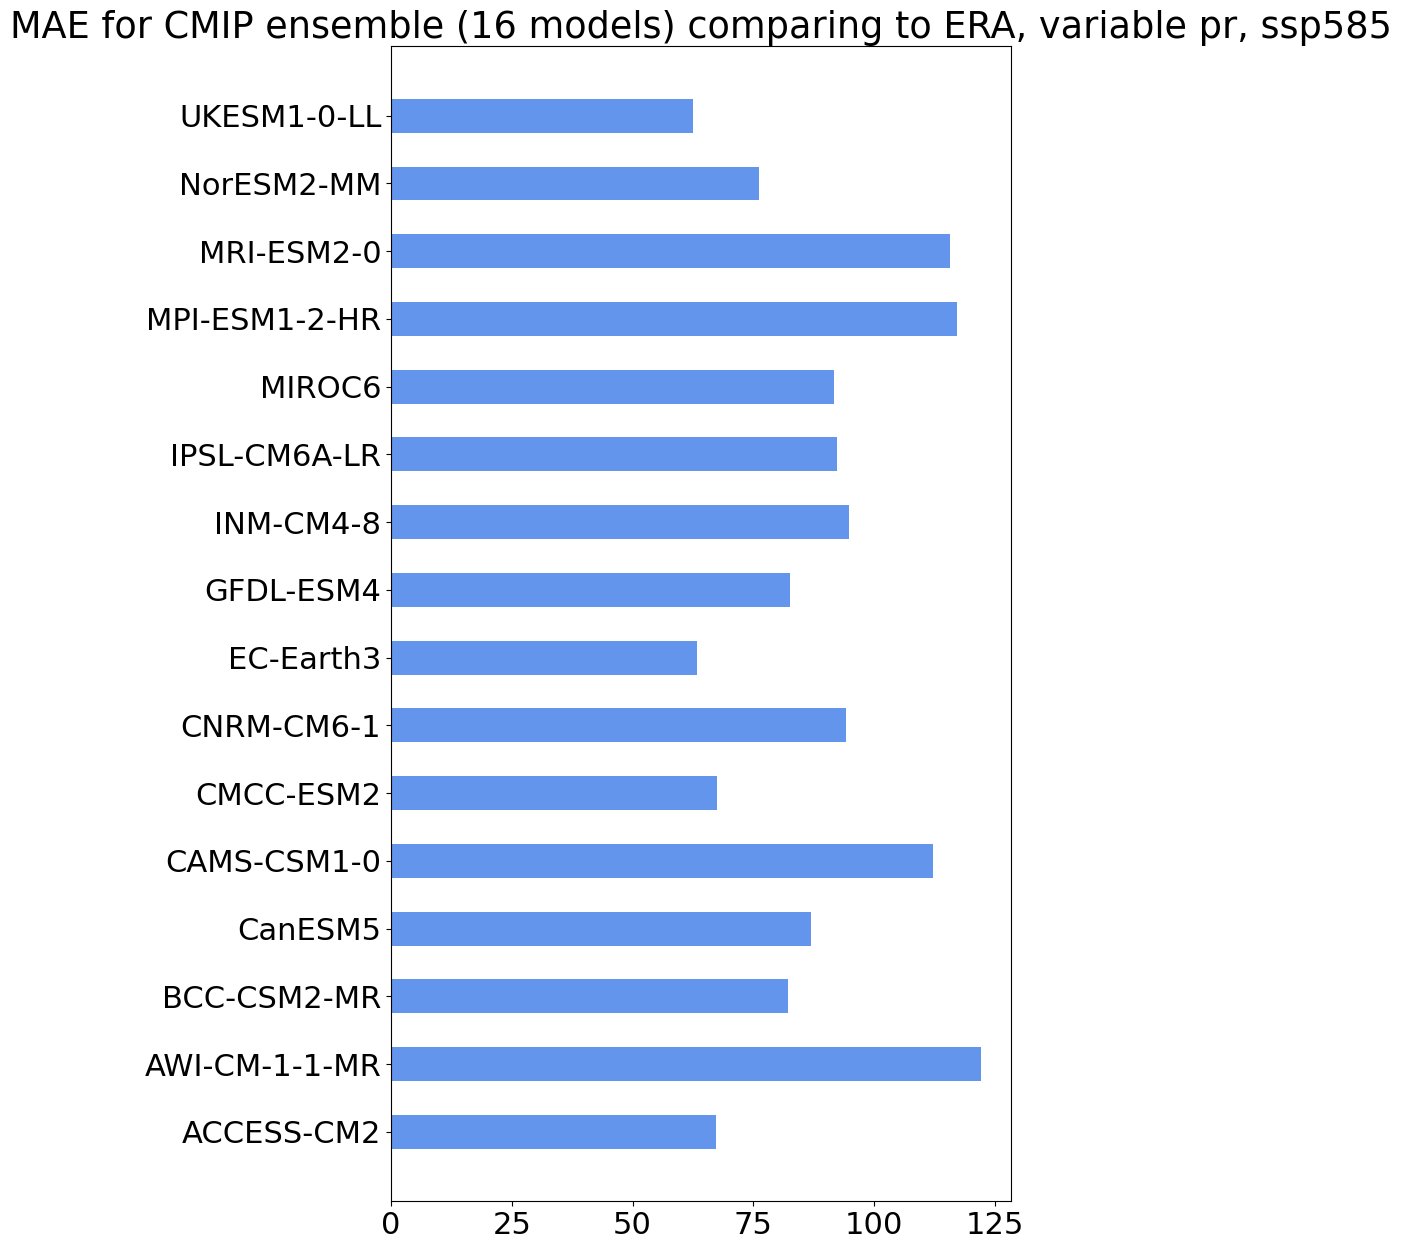

In [134]:
mae_scores_districts = correlation.calc_mae(
    ensembles,
    ens_name,
    ssp_cur,
    "precipitation",
    path_data_processed,
    path_pics,
    gdf_districts,
    should_plot = True
)
mae_scores_df = pd.DataFrame.from_dict(mae_scores_districts, orient='index').T
mae_scores_df.loc['mean'] = mae_scores_df.mean()
mae_scores_df.round(0)

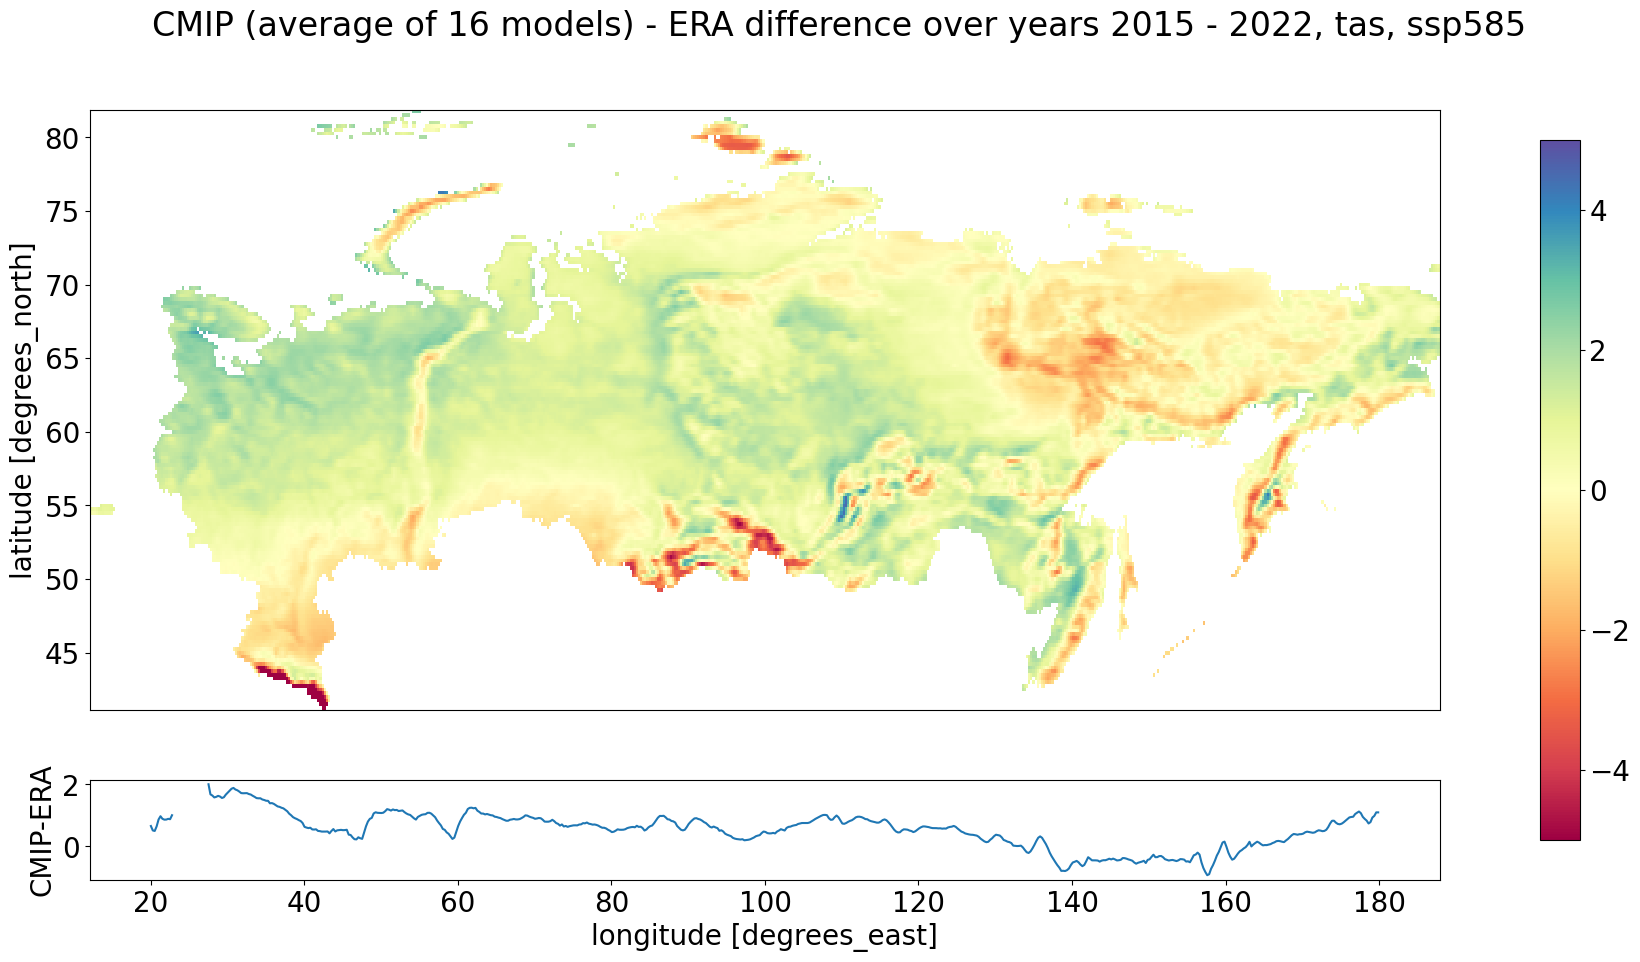

In [72]:
correlation.plot_difference(
                ensembles,
                ens_name,
                ssp_cur,
                years,
                var,
                path_data_processed,
                path_pics,
                gdf_country
)

##  Districts analysis

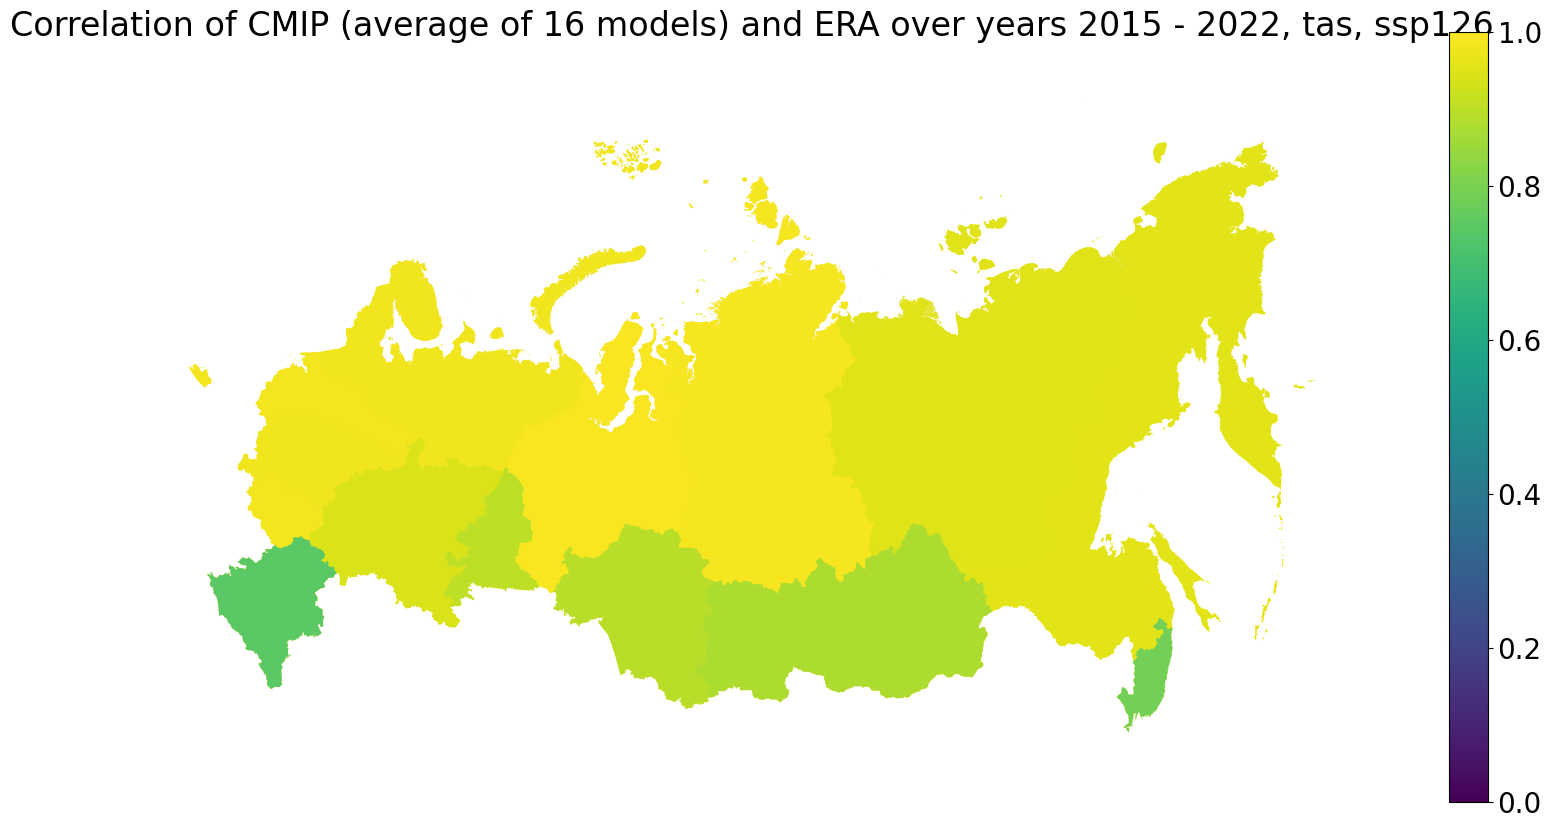

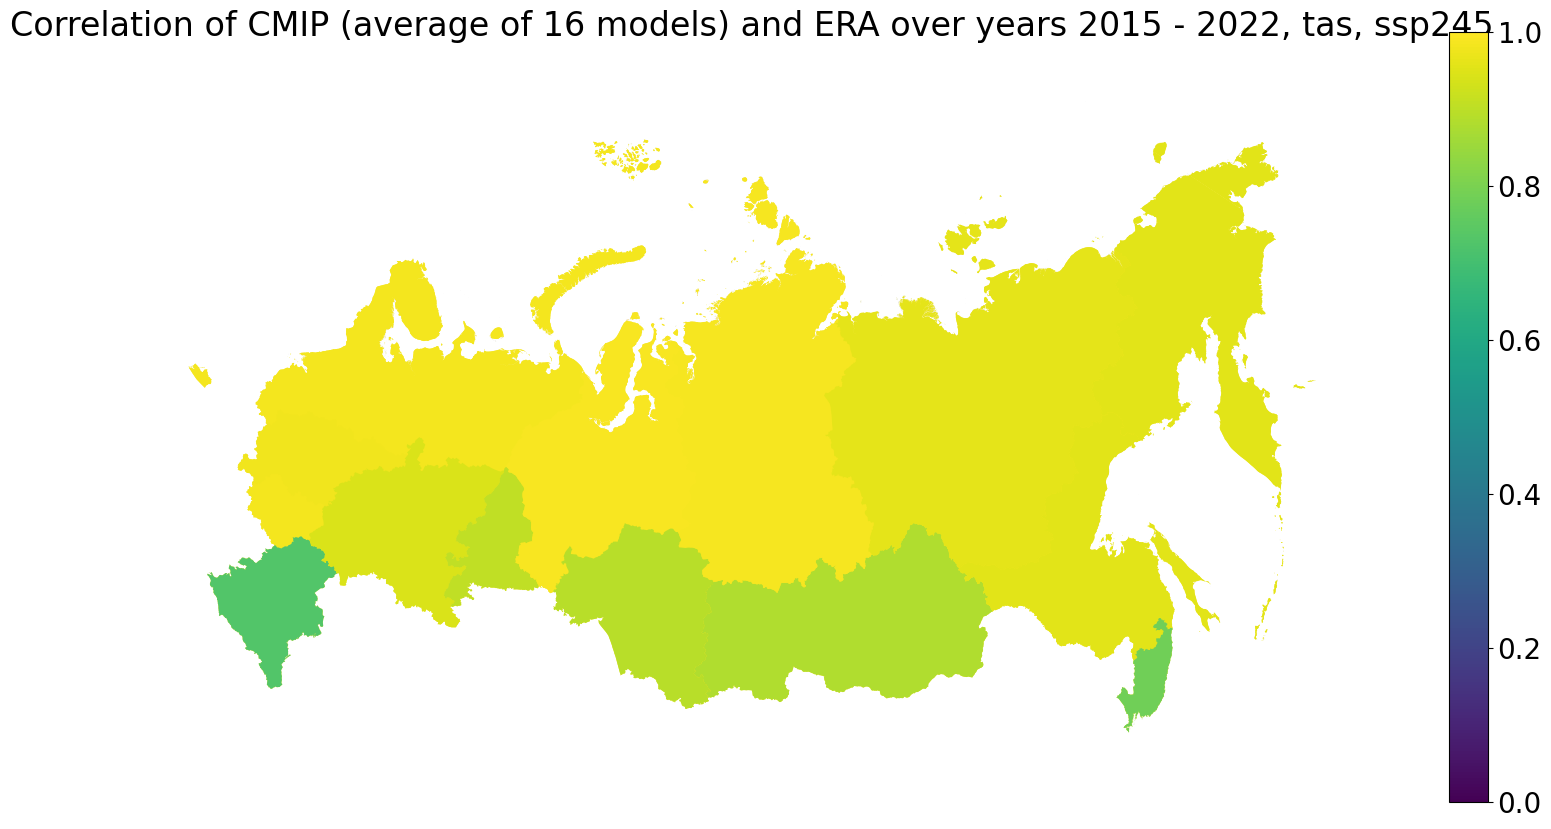

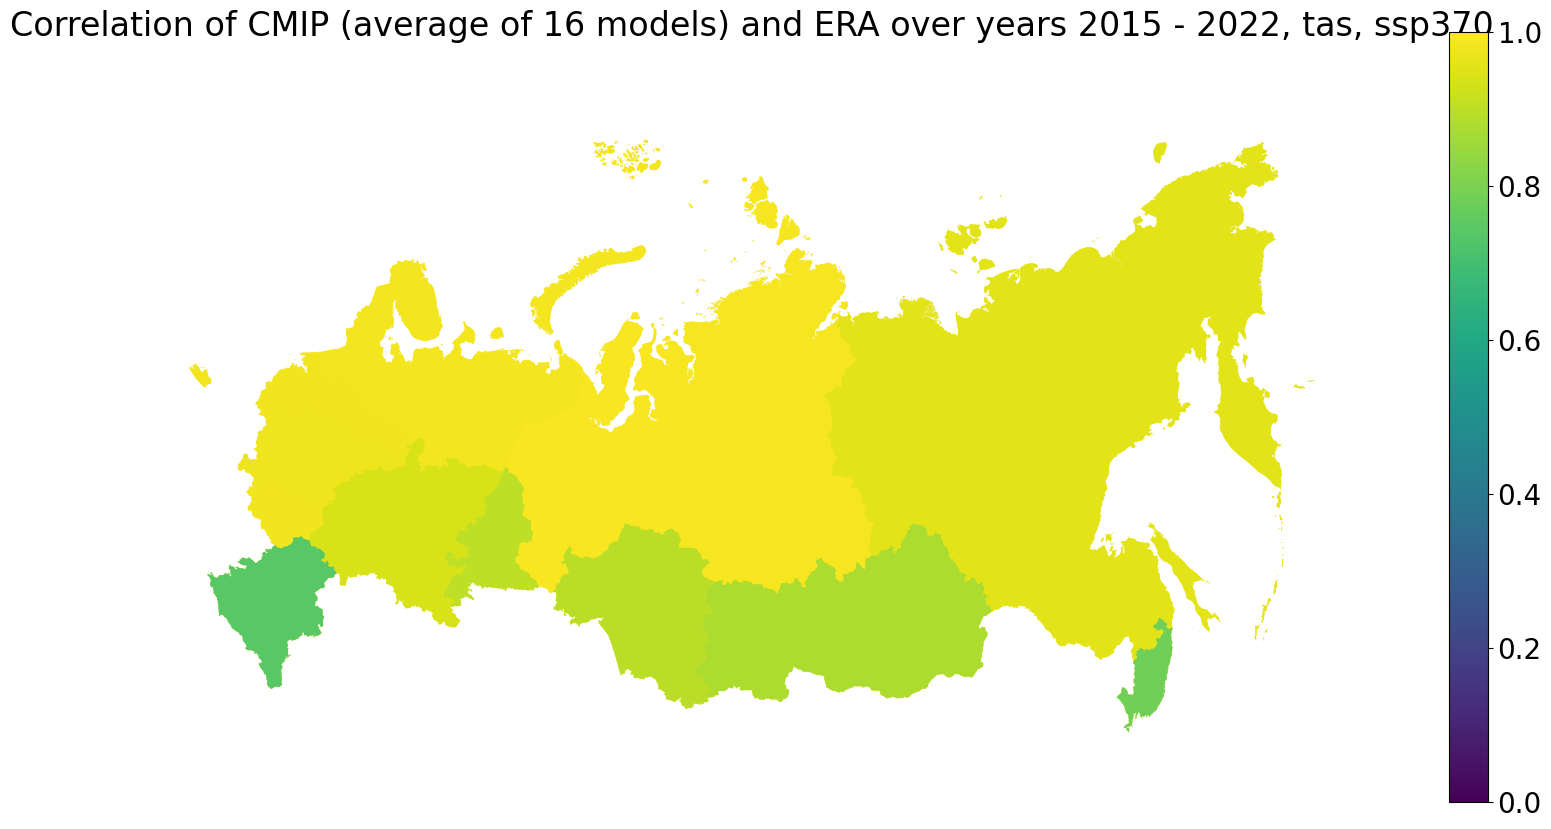

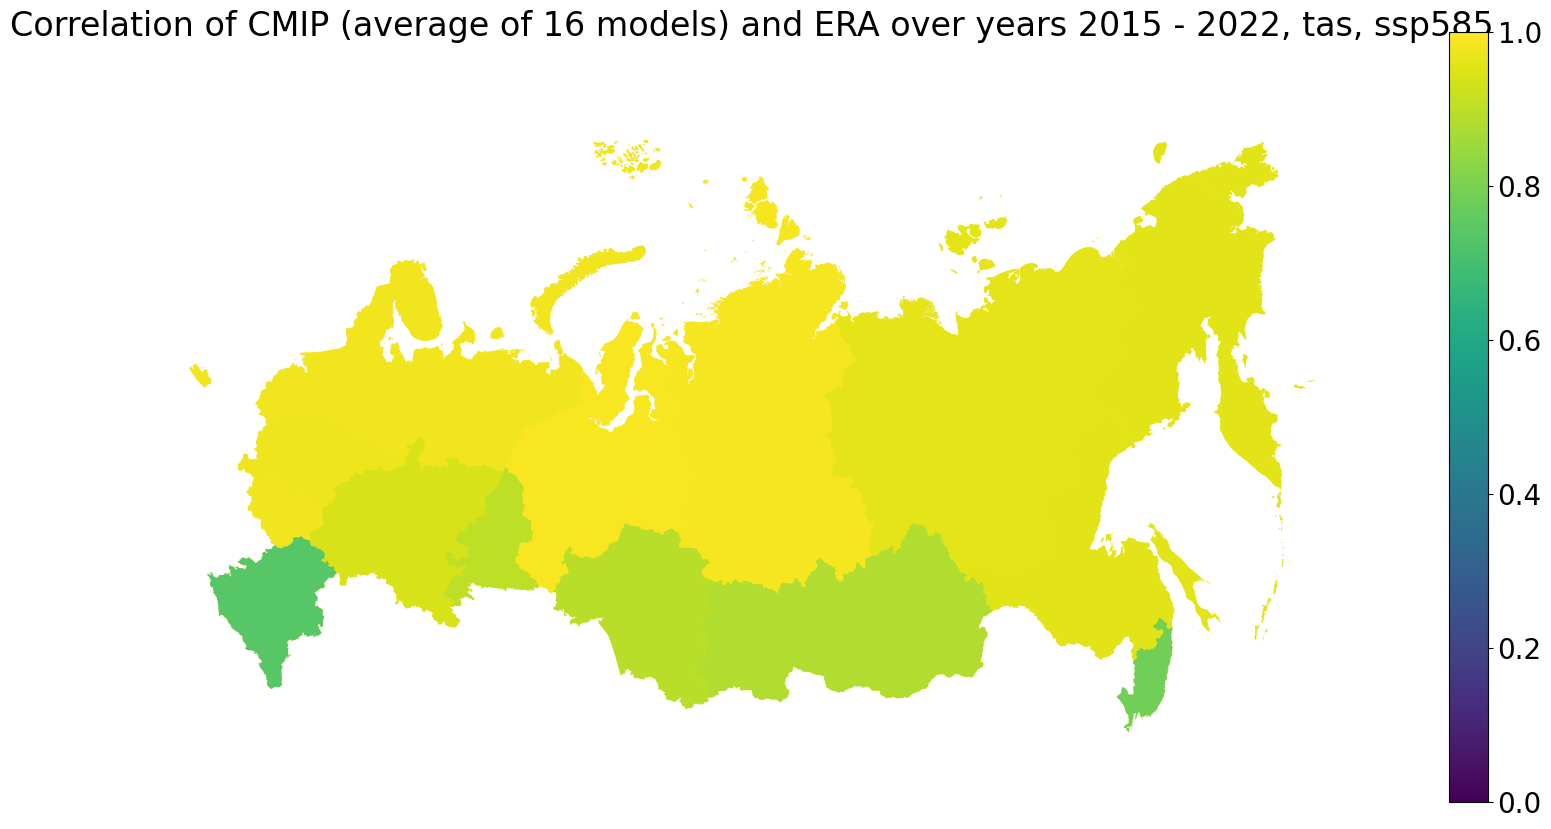

In [22]:
corr_districts = {}
corr_dict = correlation.plot_corr(
        ensembles[ens_name],
        ens_name,
        ssps,
        years,
        var,
        path_data_processed,
        path_pics,
        gdf_districts,
        corr_districts,
        "districts",
        districts
        )

## Region analysis

In [77]:
# Create dictionary to collect correlations
corr_regions = {}

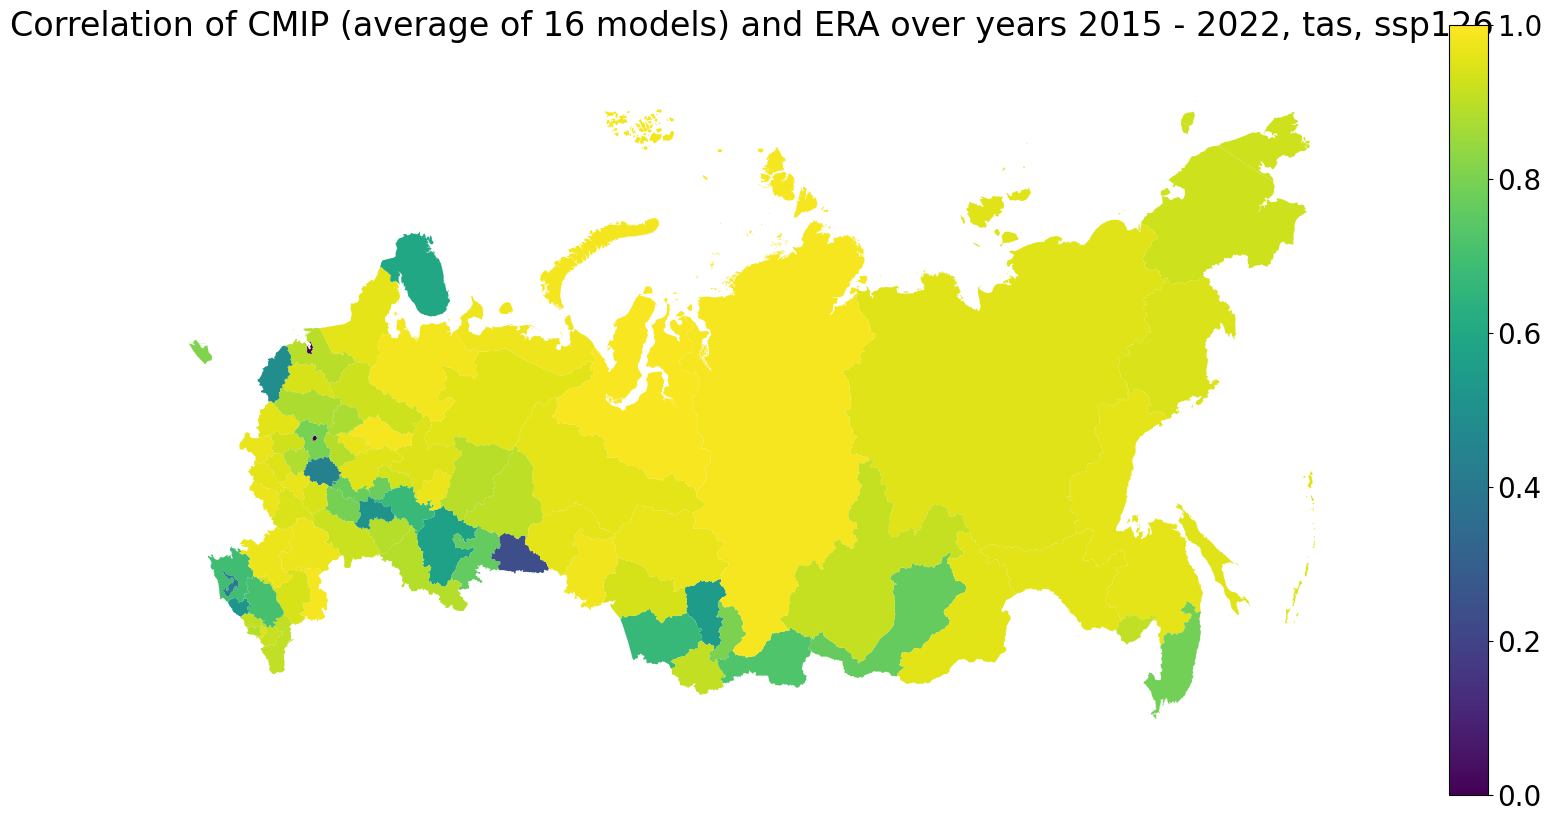

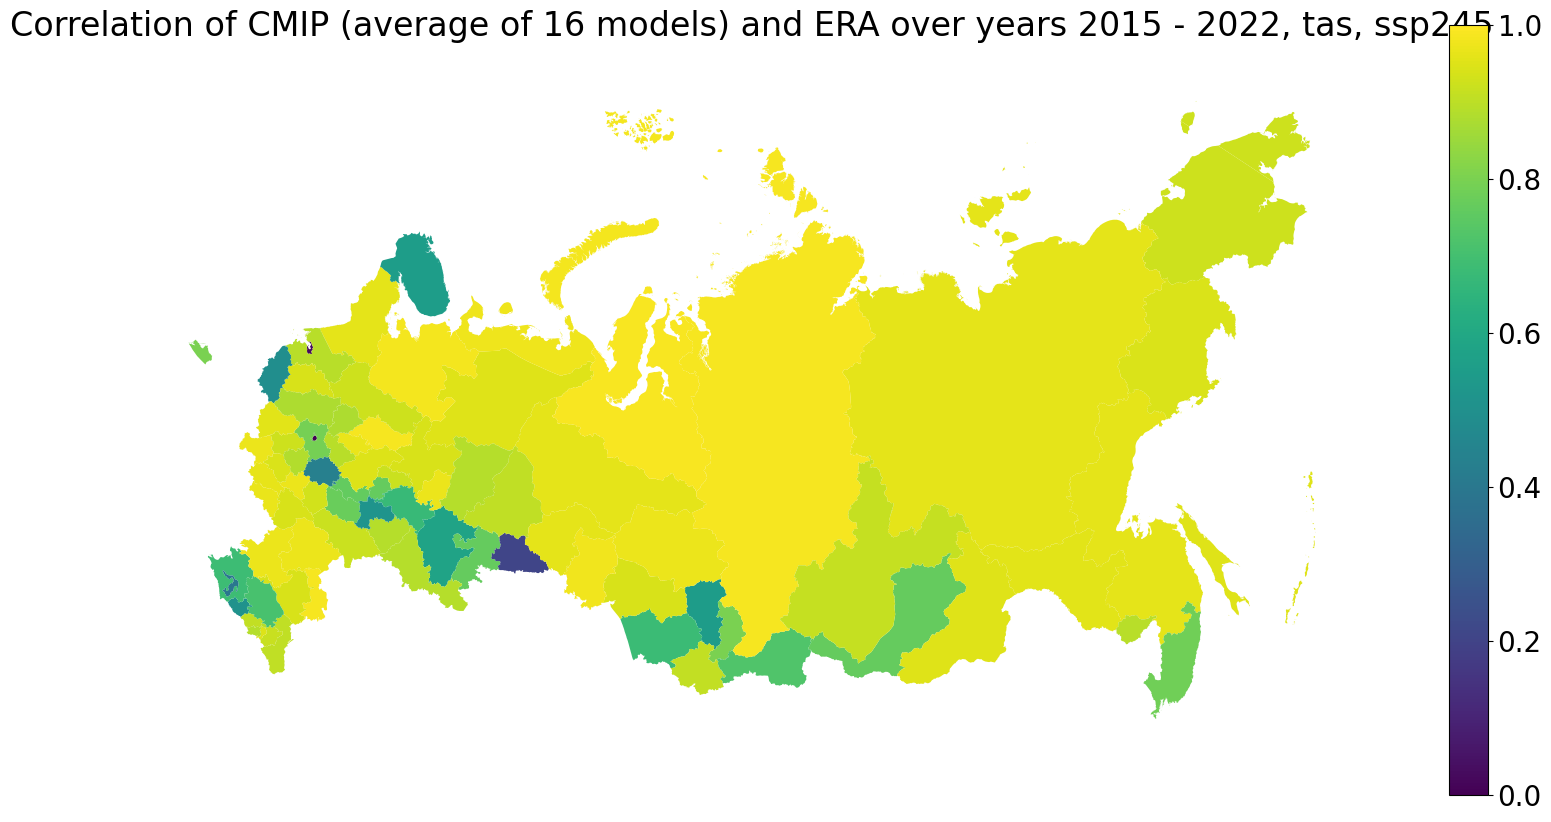

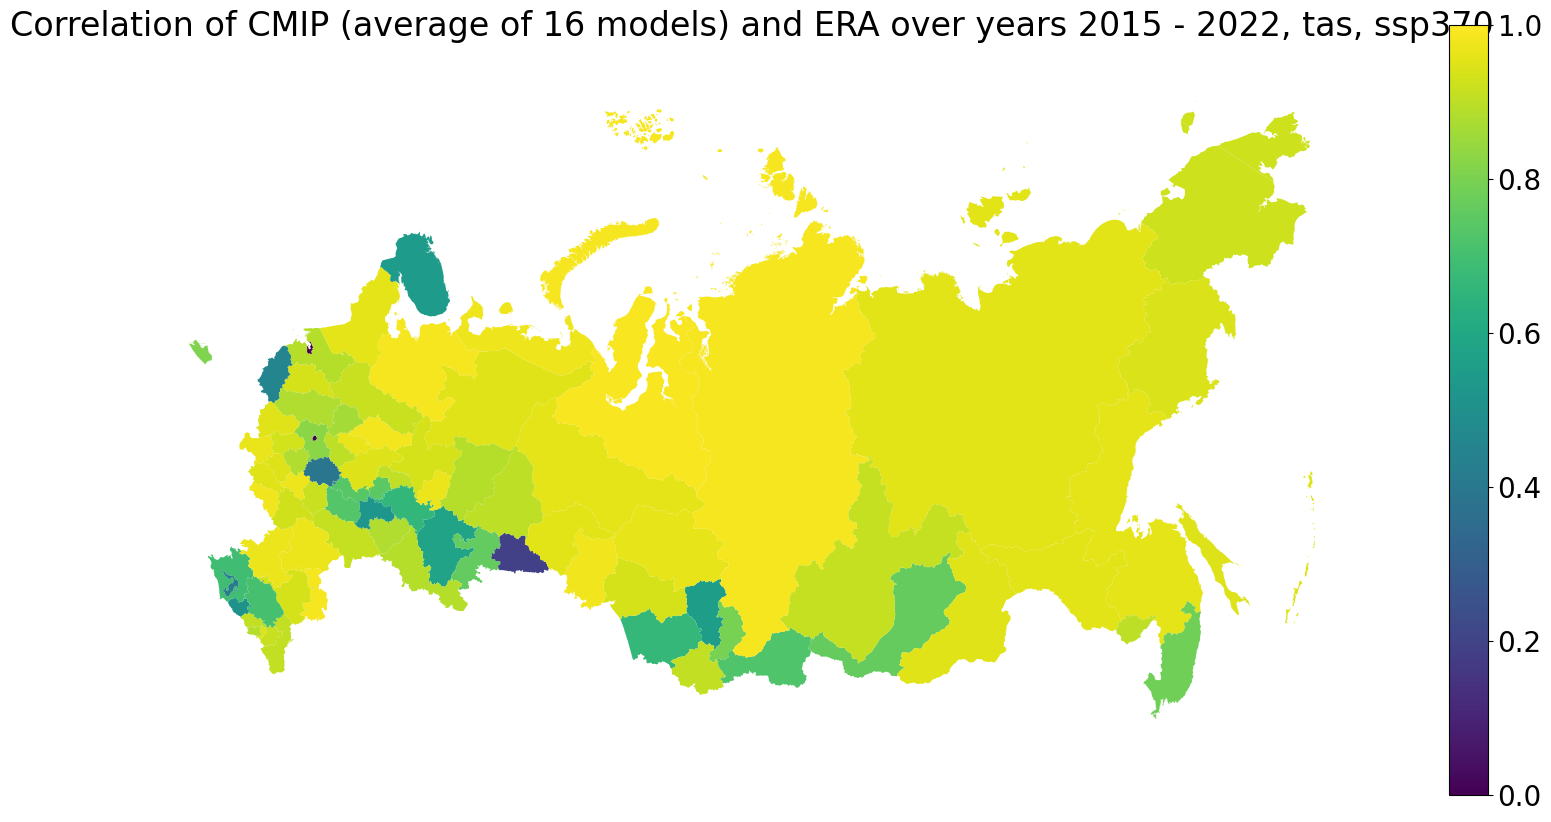

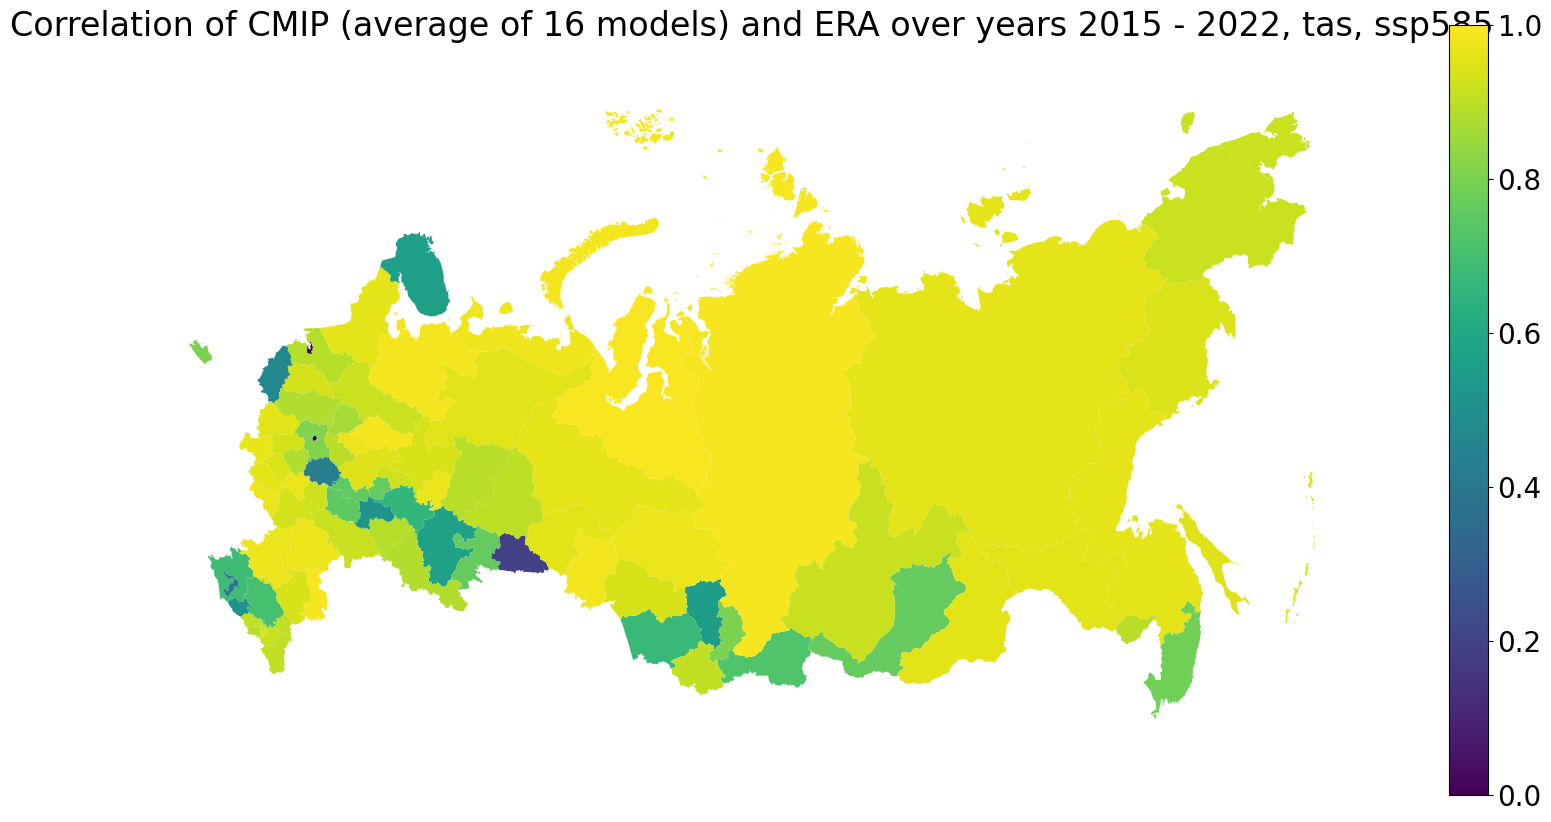

In [81]:

corr_dict = correlation.plot_corr(
        ensembles[ens_name],
        ens_name,
        ssps,
        years,
        "temperature",
        path_data_processed,
        path_pics,
        gdf_region,
        corr_regions,
        "regions"
        )

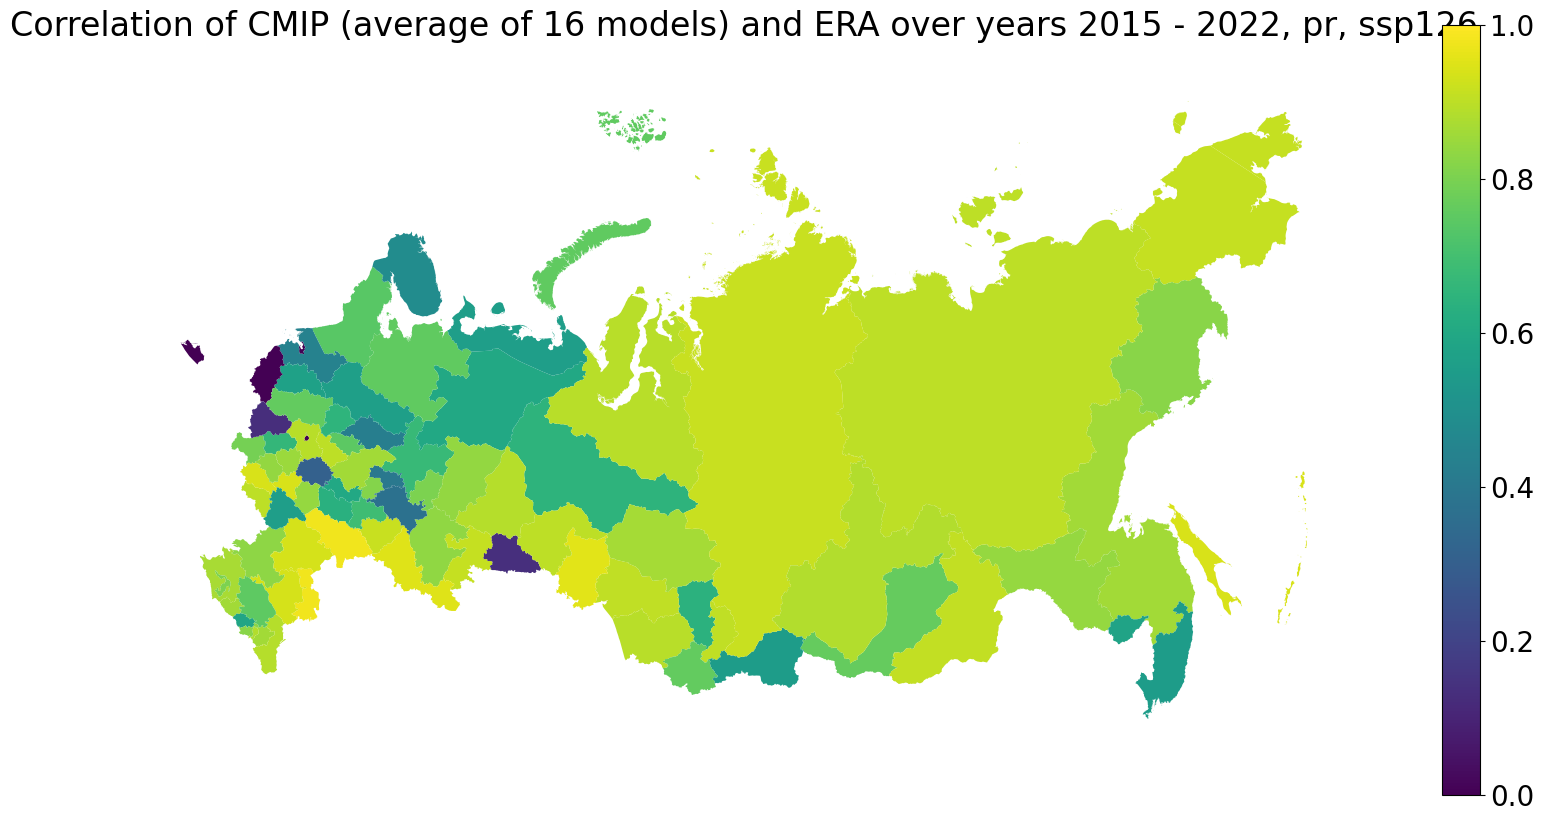

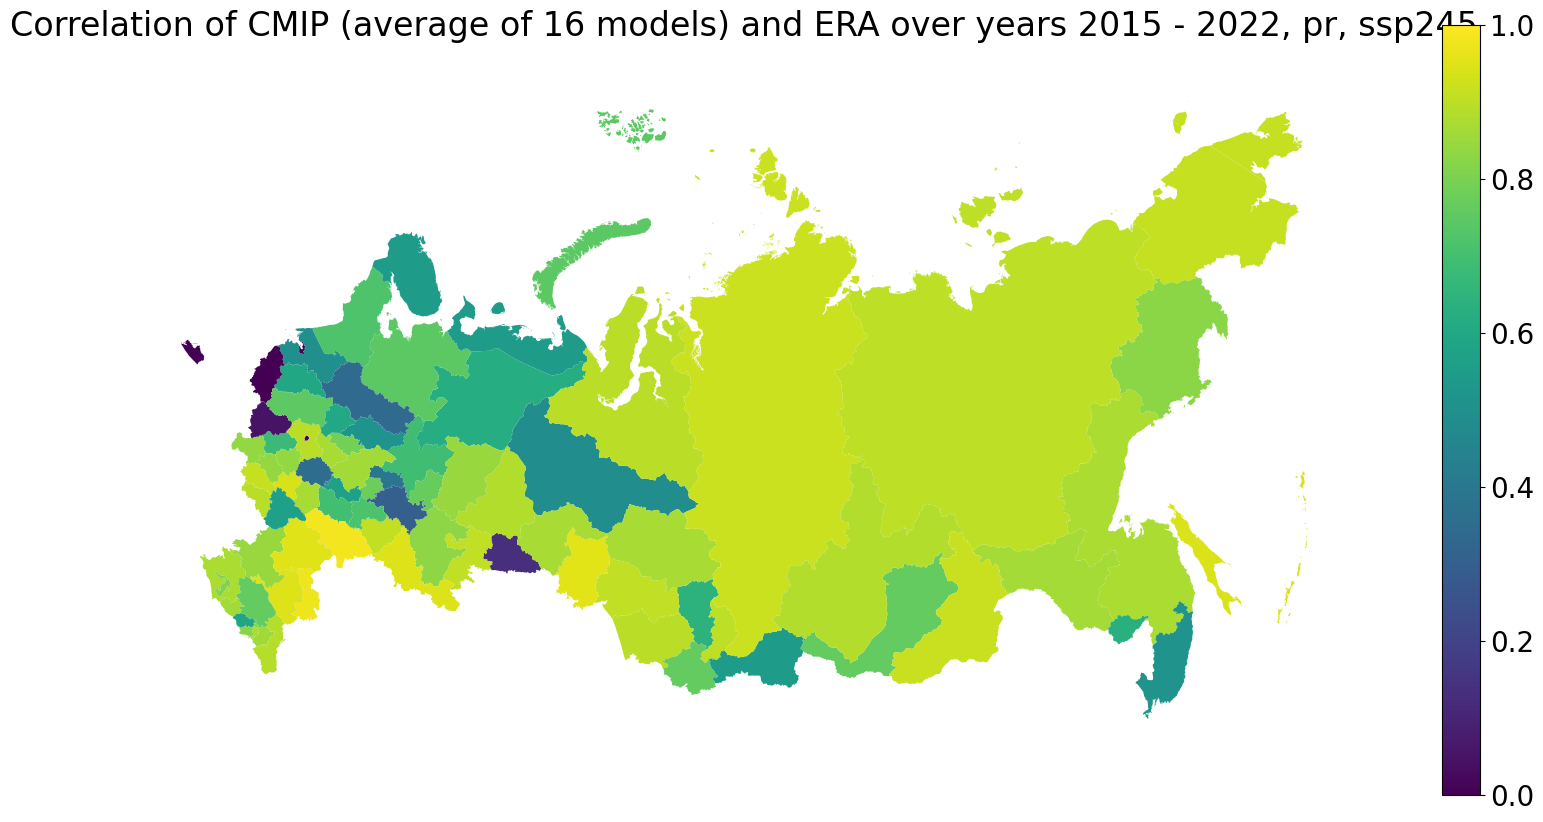

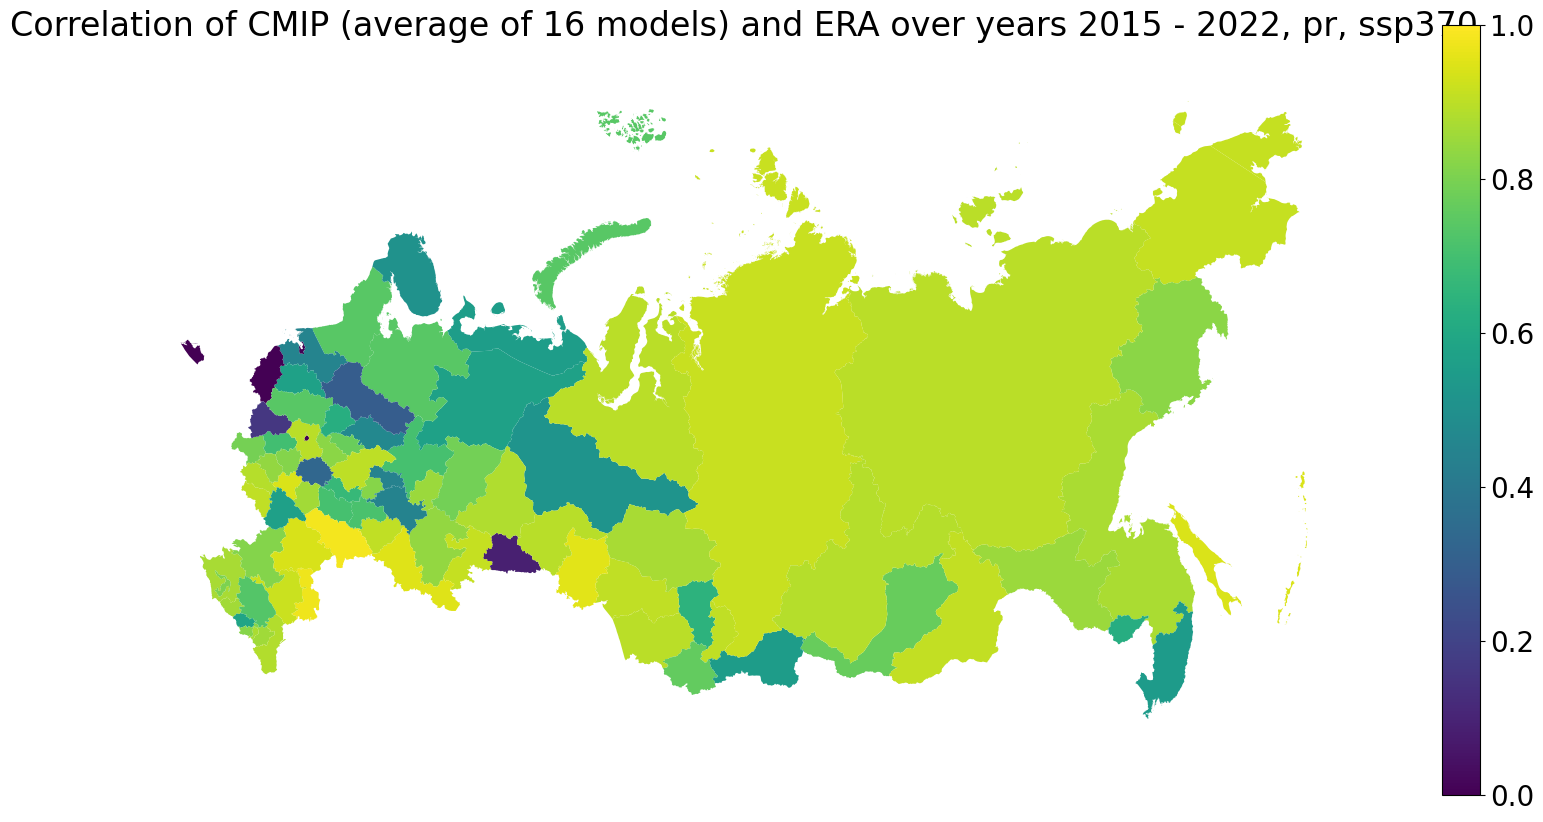

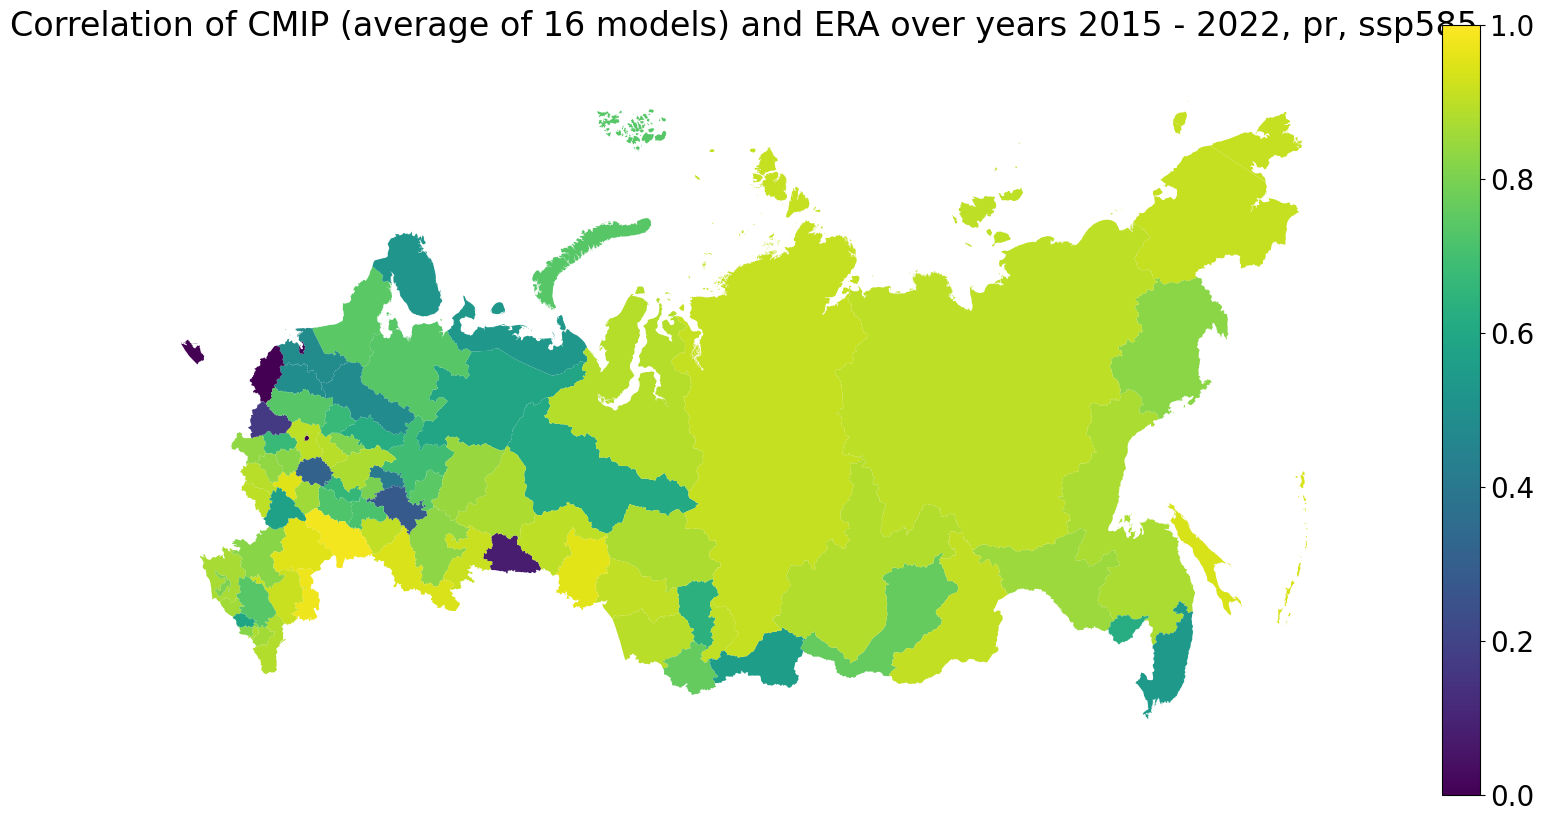

In [82]:
corr_dict = correlation.plot_corr(
        ensembles[ens_name],
        ens_name,
        ssps,
        years,
        "precipitation",
        path_data_processed,
        path_pics,
        gdf_region,
        corr_regions,
        "regions"
        )

In [32]:
# Take a closer look at correlations
corr = corr_regions["tas"]["ssp585"]
corr = corr[corr["NAME_1"].isin(["Chukot", "Yamal-Nenets", "Krasnoyarsk", "Sakha", "Maga Buryatdan"])]
corr = corr.T.iloc[1:-2, :]
corr = corr.astype(float).round(2)
corr


,21,36,55,75,78
ACCESS-CM2,0.87,0.90,0.93,0.94,0.97
AWI-CM-1-1-MR,0.91,0.94,0.95,0.98,0.98
BCC-CSM2-MR,0.88,0.89,0.93,0.96,0.98
CanESM5,0.79,0.81,0.96,0.96,0.96
CAMS-CSM1-0,0.83,0.91,0.89,0.97,0.98
CMCC-ESM2,0.92,0.93,0.91,0.96,0.94
CNRM-CM6-1,0.89,0.94,0.95,0.98,0.99
EC-Earth3,0.94,0.90,0.77,0.94,0.93
GFDL-ESM4,0.91,0.94,0.91,0.98,0.99
INM-CM4-8,0.63,0.80,0.78,0.97,0.95


In [33]:
corr.describe()

,21,36,55,75,78
count,16.000000,16.00000,16.000000,16.000000,16.000000
mean,0.864375,0.89875,0.882500,0.955625,0.968125
std,0.074473,0.04588,0.080788,0.041468,0.017595
min,0.630000,0.80000,0.670000,0.830000,0.930000
25%,0.860000,0.88750,0.872500,0.955000,0.960000
50%,0.885000,0.90500,0.910000,0.970000,0.975000
75%,0.910000,0.94000,0.930000,0.980000,0.980000
max,0.940000,0.94000,0.960000,0.990000,0.990000


## Optimal models ensemble collection

In [13]:
best_models = correlation.optimal_ensemble(
                                        ensembles,
                                        ens_name,
                                        corr_regions,
                                        ssps
)

Criterion 5 achieved for regions []
Criterion 4 achieved for regions []
Criterion 3 achieved for regions ['Kostroma', 'Belgorod', 'Chelyabinsk', 'Kurgan', 'Lipetsk', 'Tambov', "Tyumen'"]
Criterion 2 achieved for regions ['Karachay-Cherkess', 'Kemerovo', 'Khabarovsk', 'Khakass', 'Khanty-Mansiy', 'Kirov', 'Komi', 'Adygey', 'Altay', 'Amur', "Astrakhan'", 'Bashkortostan', 'Bryansk', 'Buryat', 'Chukot', 'Chuvash', 'Ingush', 'Ivanovo', 'Kabardin-Balkar', 'Kaliningrad', 'Kalmyk', 'Kaluga', 'Kursk', 'Leningrad', 'Mariy-El', 'Mordovia', 'Moscow City', 'Moskva', 'Murmansk', 'Nenets', 'Nizhegorod', 'North Ossetia', 'Novgorod', 'Novosibirsk', 'Orel', 'Orenburg', 'Penza', 'Pskov', 'Rostov', "Ryazan'", 'Sakha', 'Sakhalin', 'Samara', 'Saratov', 'Smolensk', 'Sverdlovsk', 'Tatarstan', 'Tomsk', 'Tula', "Tver'", 'Udmurt', "Ul'yanovsk", 'Vladimir', 'Volgograd', 'Vologda', 'Voronezh', 'Yamal-Nenets', "Yaroslavl'", 'Yevrey', 'Krasnoyarsk', 'Irkutsk', 'Zabaikalskiy Krai', "Perm'"]
Criterion 1 achieved for re

In [28]:
best_models_nested = {k:[v] for k,v in best_models.items()}
best_models_nested

{'Karachay-Cherkess': [[('AWI-CM-1-1-MR', 'ssp126'),
   ('GFDL-ESM4', 'ssp126'),
   ('IPSL-CM6A-LR', 'ssp126'),
   ('MPI-ESM1-2-HR', 'ssp126'),
   ('EC-Earth3', 'ssp245')]],
 'Karelia': [[('CMCC-ESM2', 'ssp126'),
   ('EC-Earth3', 'ssp126'),
   ('IPSL-CM6A-LR', 'ssp126'),
   ('MRI-ESM2-0', 'ssp126'),
   ('CNRM-CM6-1', 'ssp245'),
   ('NorESM2-MM', 'ssp245'),
   ('GFDL-ESM4', 'ssp370')]],
 'Kemerovo': [[('CNRM-CM6-1', 'ssp126'),
   ('MRI-ESM2-0', 'ssp126'),
   ('EC-Earth3', 'ssp245'),
   ('IPSL-CM6A-LR', 'ssp245'),
   ('GFDL-ESM4', 'ssp370')]],
 'Khabarovsk': [[('AWI-CM-1-1-MR', 'ssp126'),
   ('EC-Earth3', 'ssp126'),
   ('MPI-ESM1-2-HR', 'ssp126'),
   ('NorESM2-MM', 'ssp126'),
   ('GFDL-ESM4', 'ssp245'),
   ('MRI-ESM2-0', 'ssp585')]],
 'Khakass': [[('CNRM-CM6-1', 'ssp126'),
   ('GFDL-ESM4', 'ssp126'),
   ('MRI-ESM2-0', 'ssp126'),
   ('EC-Earth3', 'ssp245'),
   ('NorESM2-MM', 'ssp370')]],
 'Khanty-Mansiy': [[('AWI-CM-1-1-MR', 'ssp126'),
   ('EC-Earth3', 'ssp126'),
   ('MRI-ESM2-0', 'ssp126